In [28]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import math
import time
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.regularizers import l2, l1
from keras.metrics import BinaryAccuracy

# Data Processing

## Splitting data

In [10]:
def split_data(X, y):
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

  # Print the sizes of each set
  print(f"Training set size: {X_train.shape[0]}")
  print(f"Validation set size: {X_val.shape[0]}")
  print(f"Test set size: {X_test.shape[0]}")

  return X_train, X_val, X_test, y_train, y_val, y_test

## Scaling

In [14]:
def scale_data(scaler, X_train, X_val, X_test):
  columns = X_train.columns
  scaler.fit(np.array(X_train[columns]))
  X_test[columns] = scaler.transform(np.array(X_test[columns]))
  X_val[columns] = scaler.transform(np.array(X_val[columns]))
  X_train[columns] = scaler.transform(np.array(X_train[columns]))
  return X_train, X_val, X_test

## Neural Network

In [33]:
def create_model(input_dim, kernel_regularizer = None, dropout = False):
  model = Sequential()
    # Input layer
  model.add(Input(shape=(input_dim,)))
  # First Hidden layer
  model.add(Dense(32, activation='relu', kernel_regularizer=kernel_regularizer))
  if dropout:
    model.add(Dropout(0.2))
  model.add(Dense(16, activation='relu', kernel_regularizer=kernel_regularizer))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model


In [18]:
# Grid Search function for Hyperparameter tuning
def hyperparameter_tuning(input_dim, X_train, y_train, X_val, y_val, kernel_regularizers, lambdas, dropouts, epochs, batch_size_list):
    hyperparameter_results = []

    for kernel_regularizer in kernel_regularizers:
      for dropout in dropouts:
        for batch_size in batch_size_list:
          if kernel_regularizer is not None:
            for lambda_value in lambdas:
              reg = kernel_regularizer(lambda_value)
              print(f"Training model with kernel_regularizer = {kernel_regularizer}, lambda = {lambda_value}, dropout = {dropout}, epochs = {epochs}, batch size = {batch_size}")
              model = create_model(input_dim, reg, dropout)
              start_time = time.time()
              history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
              training_time = time.time() - start_time
          else:
            lambda_value = 0
            reg = None
            print(f"Training model with kernel_regularizer = {kernel_regularizer}, dropout = {dropout}, epochs = {epochs}, batch size = {batch_size}")
            model = create_model(input_dim, reg, dropout)
            start_time = time.time()
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
            training_time = time.time() - start_time
          hyperparameter_results.append({
                            'model': model,
                            'history': history,
                            'kernel_regularizer': kernel_regularizer,
                            'lambda_value': lambda_value,
                            'dropout': dropout,
                            'batch_size': batch_size,
                            'training_time': training_time
          })
    return hyperparameter_results

In [19]:
# Evaluate the histories and select the best model
def select_best_model(hyperparameter_results):
    best_accuracy = 0
    best_hyperparameters = None

    for result in hyperparameter_results:
        val_accuracy = result['history'].history['val_accuracy'][-1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_hyperparameters = result

    return best_hyperparameters

In [20]:
# Final evaluation function
def evaluate_final(best_hyperparameters, X_train, y_train, X_test, y_test):
    # Evaluate the best model
    train_accuracy = round((best_hyperparameters['model'].evaluate(X_train, y_train, verbose=0)[1] * 100), 2)
    test_accuracy = round((best_hyperparameters['model'].evaluate(X_test, y_test, verbose=0)[1] * 100), 2)

    # Print the best model's performance
    print(f"Best Model - batch size = {best_hyperparameters['batch_size']}, kernel_regularizer = {best_hyperparameters['kernel_regularizer']}, dropout = {best_hyperparameters['dropout']}")
    print(f"Training Accuracy: {train_accuracy}%")
    print(f"Test Accuracy: {test_accuracy}%")

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'best_hyperparameters': best_hyperparameters
    }

In [21]:
# hyperparameters
epochs = 100
kernel_regularizers = [None, l2]
lambdas = [0.01, 0.05]
dropouts = [False, True]
batch_size_list = [16, 32, 64]

# Room occupancy dataset

In [ ]:
df = pd.read_csv('/content/sample_data/room_occupancy_detection_data.csv')

In [13]:
no_time_feature_columns = df.columns.drop(["occupancy", "datetime", "hour_of_the_day", "day_number_of_the_week", "day_of_year"]).tolist()

X = df[no_time_feature_columns]
y = df["occupancy"]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

scaler = MinMaxScaler()
X_train, X_val, X_test = scale_data(scaler, X_train, X_val, X_test)

input_dim = X_train.shape[1]
threshold = 0.45
print(f"input dimension: {input_dim}")
print(f"decision threshold: {threshold}")

Training set size: 10809
Validation set size: 3603
Test set size: 3604


In [ ]:
# Perform hyperparameter tuning
hyperparameter_results = hyperparameter_tuning(input_dim, X_train, y_train, X_val, y_val,kernel_regularizers, lambdas, dropouts,epochs, batch_size_list)

# Select the best model based on validation accuracy
best_hyperparameters = select_best_model(hyperparameter_results)

Training model with kernel_regularizer = None, dropout = False, epochs = 100, batch size = 16
Training model with kernel_regularizer = None, dropout = False, epochs = 100, batch size = 32
Training model with kernel_regularizer = None, dropout = False, epochs = 100, batch size = 64
Training model with kernel_regularizer = None, dropout = True, epochs = 100, batch size = 16
Training model with kernel_regularizer = None, dropout = True, epochs = 100, batch size = 32
Training model with kernel_regularizer = None, dropout = True, epochs = 100, batch size = 64
Training model with kernel_regularizer = <class 'keras.src.regularizers.L2'>, lambda = 0.01, dropout = False, epochs = 100, batch size = 16
Training model with kernel_regularizer = <class 'keras.src.regularizers.L2'>, lambda = 0.05, dropout = False, epochs = 100, batch size = 16
Training model with kernel_regularizer = <class 'keras.src.regularizers.L2'>, lambda = 0.01, dropout = False, epochs = 100, batch size = 32
Training model with

In [ ]:
# Evaluate the best model on the test set
final_results = evaluate_final(best_hyperparameters, X_train, y_train, X_test, y_test)

# Print final results
print(f"Final Results: {final_results}")

Best Model - batch size = 16, kernel_regularizer = None, dropout = False
Training Accuracy: 91.69%
Test Accuracy: 90.2%
Final Results: {'train_accuracy': 91.69, 'test_accuracy': 90.2, 'best_hyperparameters': {'model': <keras.src.engine.sequential.Sequential object at 0x7ba20bea5240>, 'history': <keras.src.callbacks.History object at 0x7ba20b60ea70>, 'kernel_regularizer': None, 'lambda_value': 0, 'dropout': False, 'batch_size': 16, 'training_time': 142.95032167434692}}


In [ ]:
best_batch_size = final_results['best_hyperparameters']['batch_size']
best_epochs = epochs
best_model = best_hyperparameters["model"]

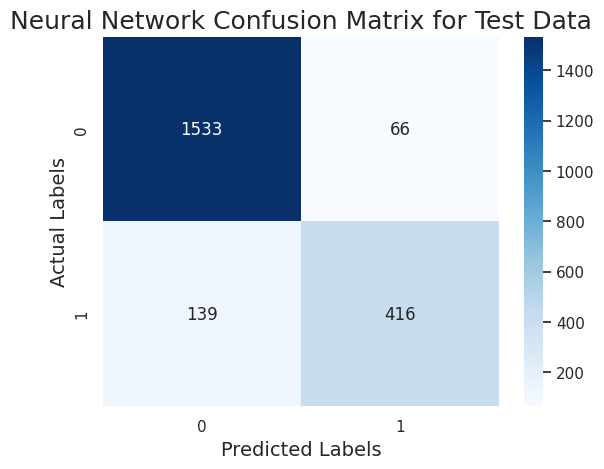

In [ ]:
y_pred = best_model.predict(X_test, verbose = 0)
y_pred = [1 if i >= threshold else 0 for i in y_pred]

plt.title("Neural Network Confusion Matrix for Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('Actual Labels', fontsize=14)
plt.show()

# Augmented Tera dataset

In [25]:
df = pd.read_csv('/content/sample_data/augmented_tera.csv')

In [26]:
no_time_feature_columns = df.columns.drop(["occupancy", "datetime", "hour_of_the_day", "day_number_of_the_week", "day_of_year"]).tolist()

X = df[no_time_feature_columns]
y = df["occupancy"]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

scaler = MinMaxScaler()
X_train, X_val, X_test = scale_data(scaler, X_train, X_val, X_test)

input_dim = X_train.shape[1]
threshold = 0.45
print(f"input dimension: {input_dim}")
print(f"decision threshold: {threshold}")

Training set size: 10809
Validation set size: 3603
Test set size: 3604
input dimension: 17
decision threshold: 0.45


In [29]:
# Perform hyperparameter tuning
hyperparameter_results = hyperparameter_tuning(input_dim, X_train, y_train, X_val, y_val,kernel_regularizers, lambdas, dropouts,epochs, batch_size_list)

# Select the best model based on validation accuracy
best_hyperparameters = select_best_model(hyperparameter_results)

Training model with kernel_regularizer = None, dropout = False, epochs = 100, batch size = 16
Training model with kernel_regularizer = None, dropout = False, epochs = 100, batch size = 32
Training model with kernel_regularizer = None, dropout = False, epochs = 100, batch size = 64
Training model with kernel_regularizer = None, dropout = True, epochs = 100, batch size = 16
Training model with kernel_regularizer = None, dropout = True, epochs = 100, batch size = 32
Training model with kernel_regularizer = None, dropout = True, epochs = 100, batch size = 64
Training model with kernel_regularizer = <class 'keras.src.regularizers.regularizers.L2'>, lambda = 0.01, dropout = False, epochs = 100, batch size = 16
Training model with kernel_regularizer = <class 'keras.src.regularizers.regularizers.L2'>, lambda = 0.05, dropout = False, epochs = 100, batch size = 16
Training model with kernel_regularizer = <class 'keras.src.regularizers.regularizers.L2'>, lambda = 0.01, dropout = False, epochs = 1

In [30]:
# Evaluate the best model on the test set
final_results = evaluate_final(best_hyperparameters, X_train, y_train, X_test, y_test)

# Print final results
print(f"Final Results: {final_results}")

Best Model - batch size = 16, kernel_regularizer = None, dropout = False
Training Accuracy: 85.88%
Test Accuracy: 84.54%
Final Results: {'train_accuracy': 85.88, 'test_accuracy': 84.54, 'best_hyperparameters': {'model': <Sequential name=sequential_5, built=True>, 'history': <keras.src.callbacks.history.History object at 0x78d921122e00>, 'kernel_regularizer': None, 'lambda_value': 0, 'dropout': False, 'batch_size': 16, 'training_time': 179.73412108421326}}


In [31]:
best_batch_size = final_results['best_hyperparameters']['batch_size']
best_epochs = epochs
best_model = best_hyperparameters["model"]

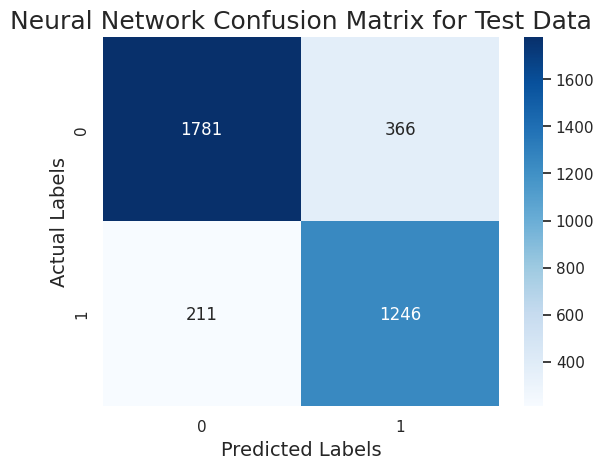

In [32]:
y_pred = best_model.predict(X_test, verbose = 0)
y_pred = [1 if i >= threshold else 0 for i in y_pred]

plt.title("Neural Network Confusion Matrix for Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('Actual Labels', fontsize=14)
plt.show()